<a href="https://colab.research.google.com/github/rjnakano/manejo-inventarios-pdg/blob/main/Notebooks/TDG041821V5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
pip install --upgrade kmodes

In [15]:
from google.colab import drive
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

from kmodes.kprototypes import KPrototypes

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()

from plotnine import *
import plotnine

In [2]:
plot_kwds = {'alpha' : 0.5, 's' : 1, 'linewidths':0}

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Dataset de inventarios sin dimensiones de los productos
data5 = pd.read_csv("/content/gdrive/MyDrive/TDGdata/dfNoDims.csv")

In [5]:
data5

,AISLE,IG,HTS,PLANNING,ABC,UOM,CAT,COSTX,QTYVAR,CONTRPERC
0,17,IG56,HTS119,1/1,B,PC,CAT17,-289.8802,-2.63,0.01
1,17,IG56,HTS119,1/1,B,PC,CAT17,289.5527,25.00,0.00
2,17,IG56,HTS119,1/1,C,PC,CAT17,1111.3121,50.00,0.00
3,17,IG56,HTS119,1/1,B,PC,CAT17,-266.8633,-9.09,0.00
4,15,IG56,HTS119,1/1,C,PC,CAT17,-517.0436,-11.11,0.00
...,...,...,...,...,...,...,...,...,...,...
16239,23,IG5,HTS67,1/0,C,BX,CAT2,316.3834,1.00,0.00
16240,21,IG5,HTS67,1/0,C,BX,CAT2,626.9100,1.00,0.00
16241,22,IG5,HTS67,1/0,C,BX,CAT2,4959.6974,136.36,0.00
16242,24,IG5,HTS67,1/0,C,BX,CAT2,-1322.5860,-100.00,0.00


In [6]:
data5['AISLE']=data5['AISLE'].astype(str)

In [7]:
data5 =  data5.drop(['IG','HTS','PLANNING','ABC','UOM','CAT','CONTRPERC'], axis=1)

In [8]:
data5.sample(5)

,AISLE,COSTX,QTYVAR
14142,32,836.9763,1.0
15256,12,74.2818,1.0
9792,12,10.2813,0.1
13605,3,3509.4310,1.0
16161,27,-22017.8489,-100.0


In [9]:
numdf = data5[list(data5.select_dtypes('float64').columns)]
scaled_features = StandardScaler().fit_transform(numdf.values)
scaled_features_df = pd.DataFrame(scaled_features, index=numdf.index, columns=numdf.columns)
scaled_features_df

,COSTX,QTYVAR
0,-0.029671,-0.037167
1,0.092655,-0.006905
2,0.266138,0.020477
3,-0.024812,-0.044242
4,-0.077628,-0.046455
...,...,...
16239,0.098319,-0.033191
16240,0.163875,-0.033191
16241,1.078580,0.115063
16242,-0.247688,-0.143812


In [11]:
catdf = data5[list(data5.select_dtypes('object').columns)]

In [12]:
data5 = pd.concat((catdf, scaled_features_df), axis = 1)
data5

,AISLE,COSTX,QTYVAR
0,17,-0.029671,-0.037167
1,17,0.092655,-0.006905
2,17,0.266138,0.020477
3,17,-0.024812,-0.044242
4,15,-0.077628,-0.046455
...,...,...,...
16239,23,0.098319,-0.033191
16240,21,0.163875,-0.033191
16241,22,1.078580,0.115063
16242,24,-0.247688,-0.143812


In [13]:
from sklearn.metrics import silhouette_score
import time

dataNum=scaled_features_df.to_numpy()
dataCat=catdf.to_numpy()
N = data5.shape[0]

# gamma = 0.5 (constante)
catWeight=0.5

start_time = time.time()

# Inicializamos la matriz de distancias con ceros
scores = [ [ 0 for i in range(N) ] for j in range(N) ]

# Calculamos la mitad de la matriz distancias
for i in range(N):
  for j in range(i+1,N):
    scores[i][j]=np.sum((dataNum[i] - dataNum[j]) ** 2) + catWeight * np.sum(dataCat[i]!=dataCat[j])
print("Matriz de distancias --- %s seconds ---" % (time.time() - start_time))

# Completamos la matriz
for i in range(0,N):
  for j in range(0,i):
    scores[i][j]=scores[j][i]
print("Espejo --- %s seconds ---" % (time.time() - start_time))

Matriz de distancias --- 2532.3454661369324 seconds ---
Espejo --- 2630.1177566051483 seconds ---


In [18]:
scores[0][0:10]

[0,
 0.01587930225839,
 0.09082574716954744,
 7.367192442936448e-05,
 0.5023861372618001,
 6.902833274497345,
 0.5373217610159332,
 3.4486326421919746,
 0.5539302934870542,
 0.5525377103689751]

In [19]:
catColumnsPos = [data5.columns.get_loc(col) for col in list(data5.select_dtypes('object').columns)]

In [20]:
# gamma = 0.5 (constante)

cost = []
silueta = []
start_time = time.time()

for k in (list(range(1,6)) + [10]):
  try:
    kprototype = KPrototypes(n_jobs = -1, n_clusters = k, init = 'Huang', gamma = 0.5, random_state = 0)
    kprototype.fit_predict(data5, categorical = catColumnsPos)
    cost.append(kprototype.cost_)
    print('k: {}'.format(k))
    print("--- %s seconds ---" % (time.time() - start_time))
    if k != 1:
      silhouette_coeff = silhouette_score(scores, kprototype.labels_, metric='precomputed')
      silueta.append(silhouette_coeff)
      print("Coeficiente silueta --- %s seconds ---" % (time.time() - start_time))
      print(silhouette_coeff)

  except:
    break

k: 1
--- 24.994406938552856 seconds ---
k: 2
--- 120.2389395236969 seconds ---
Coeficiente silueta --- 176.84144711494446 seconds ---
0.9977783237909517
k: 3
--- 297.1411626338959 seconds ---
Coeficiente silueta --- 349.65300250053406 seconds ---
0.8949529478026805
k: 4
--- 497.6926951408386 seconds ---
Coeficiente silueta --- 551.345104932785 seconds ---
0.8832445390264407
k: 5
--- 784.0508525371552 seconds ---
Coeficiente silueta --- 837.9803493022919 seconds ---
0.3733142029822963
k: 10
--- 1120.8199048042297 seconds ---
Coeficiente silueta --- 1173.301395893097 seconds ---
0.07503284315205792


In [22]:
df_cost = pd.DataFrame({'Cluster':list(range(1,6)) + [10], 'Cost':cost})
df_silueta = pd.DataFrame({'Cluster':list(range(2,6)) + [10], 'Coeficiente':silueta})

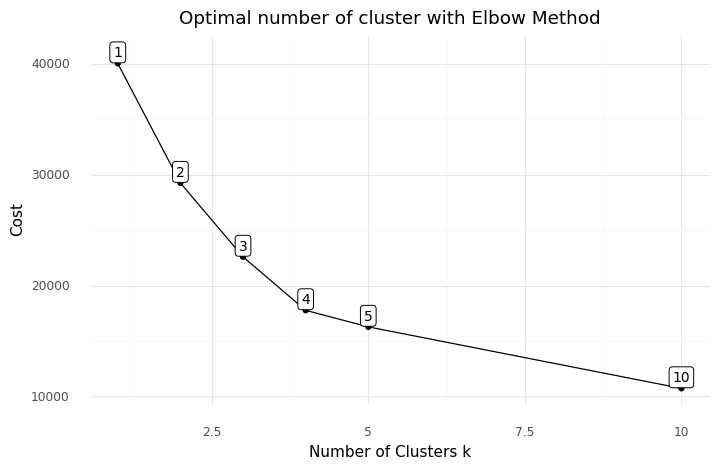

<ggplot: (8732595481609)>

In [23]:
# Codo
plotnine.options.figure_size = (8, 4.8)
(
ggplot(data = df_cost)+
geom_line(aes(x = 'Cluster',
y = 'Cost'))+
geom_point(aes(x = 'Cluster',
y = 'Cost'))+
geom_label(aes(x = 'Cluster',
y = 'Cost',
label = 'Cluster'),
size = 10,
nudge_y = 1000) +
labs(title = 'Optimal number of cluster with Elbow Method')+
xlab('Number of Clusters k')+
ylab('Cost')+
theme_minimal()
)

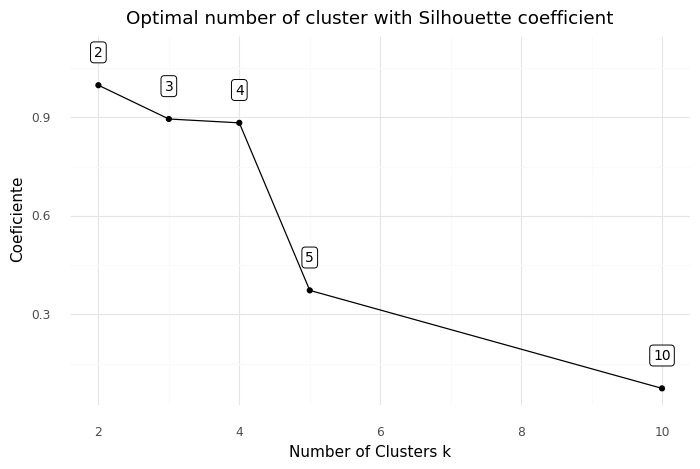

<ggplot: (8732595486305)>

In [24]:
# Coeficiente silueta
plotnine.options.figure_size = (8, 4.8)
(
ggplot(data = df_silueta)+
geom_line(aes(x = 'Cluster',
y = 'Coeficiente'))+
geom_point(aes(x = 'Cluster',
y = 'Coeficiente'))+
geom_label(aes(x = 'Cluster',
y = 'Coeficiente',
label = 'Cluster'),
size = 10,
nudge_y = 0.1) +
labs(title = 'Optimal number of cluster with Silhouette coefficient')+
xlab('Number of Clusters k')+
ylab('Coeficiente')+
theme_minimal()
)

In [25]:
# Fit the cluster 
# k = 2
import time
start_time = time.time()
kprototype = KPrototypes(n_jobs = -1, n_clusters = 2, init = 'Huang', gamma = 0.5, random_state = 0)
kprototype.fit_predict(data5, categorical = catColumnsPos)
print("--- %s seconds ---" % (time.time() - start_time))

--- 90.7376959323883 seconds ---


In [26]:
print(kprototype.cluster_centroids_)

[['1.704838539160577' '34.56854838485847' '2']
 ['-0.0009450906592202464' '-0.01916334681020865' '2']]


In [27]:
data5['Cluster Labels'] = kprototype.labels_

In [29]:
contingency = pd.crosstab(data5['Cluster Labels'], data5['AISLE']) 
contingency

AISLE,0,1,10,11,12,13,14,15,16,17,18,19,2,20,21,22,23,24,25,26,27,28,29,3,30,31,32,33,34,35,37,38,39,4,40,41,5,6,7,8,88,9,99
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,1,0,1,0,0,0,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
1,70,222,636,786,1056,826,784,851,553,586,340,339,1113,247,250,226,89,87,134,82,98,169,147,805,156,169,250,178,105,81,671,186,176,750,121,157,220,193,665,704,83,699,175


In [31]:
data5[data5['Cluster Labels']==0].describe()

,COSTX,QTYVAR,Cluster Labels
count,9.000000,9.000000,9.0
mean,1.704839,34.568548,0.0
std,1.460157,20.958121,0.0
min,0.274541,17.380272,0.0
25%,1.024759,20.885088,0.0
50%,1.068687,22.747022,0.0
75%,1.926229,38.212026,0.0
max,5.242270,80.959836,0.0
